In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import fitsio
import numpy as np
from fpfs import pltutil
import astropy.io.ascii as pyascii
import matplotlib.pylab as plt
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


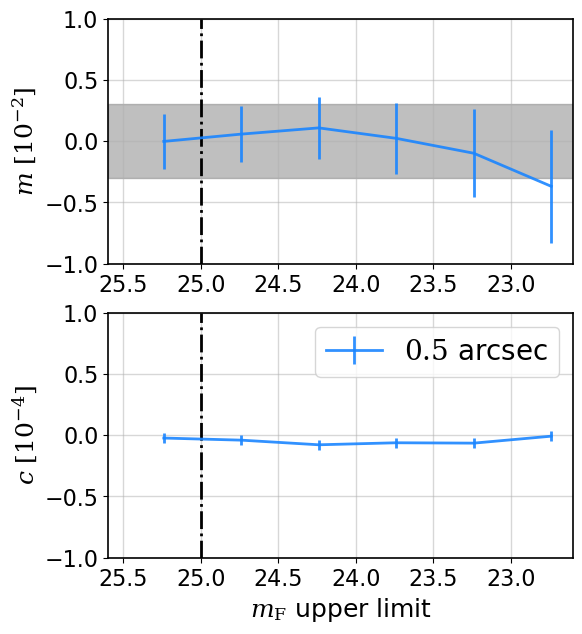

In [34]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)

# read data
outs = pyascii.read('sum_n1_basic1/try1_bin_M00.csv')
x=outs['binave']
y1=outs['mbias']
yerr=outs['merr']
z1=outs['cbias']
zerr=outs['cerr']

ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.errorbar(np.array(x)+0.04,np.array(y1)*1e2,np.array(yerr)*1e2,label=r'$0.5$ arcsec',color=pltutil.colors[1])

ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(22.6,25.6)
ax.axvline(25.,color='black',ls='-.')
ax.set_ylim(-1,1.)

ax.invert_xaxis()
ax.axhspan(-0.3,0.3,0,100,color='gray',alpha=0.5)
ax.grid()


ax=axes[1]
ax.errorbar(np.array(x)+0.04,np.array(z1)*1e4,np.array(zerr)*1e4,label=r'$0.5$ arcsec',color=pltutil.colors[1])
ax.legend()
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(22.6,25.6)
ax.axvline(25.,color='black',ls='-.')

ax.set_ylim(-1,1)
ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
plt.show()

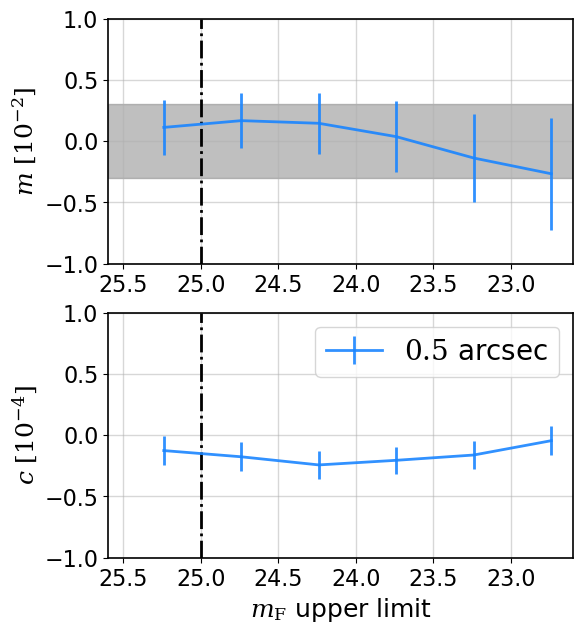

In [36]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)

# read data
outs = pyascii.read('sum_n2_basic1/try1_bin_M00.csv')
x=outs['binave']
y1=outs['mbias']
yerr=outs['merr']
z1=outs['cbias']
zerr=outs['cerr']

ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.errorbar(np.array(x)+0.04,np.array(y1)*1e2,np.array(yerr)*1e2,label=r'$0.5$ arcsec',color=pltutil.colors[1])

ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(22.6,25.6)
ax.axvline(25.,color='black',ls='-.')
ax.set_ylim(-1,1.)

ax.invert_xaxis()
ax.axhspan(-0.3,0.3,0,100,color='gray',alpha=0.5)
ax.grid()


ax=axes[1]
ax.errorbar(np.array(x)+0.04,np.array(z1)*1e4,np.array(zerr)*1e4,label=r'$0.5$ arcsec',color=pltutil.colors[1])
ax.legend()
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(22.6,25.6)
ax.axvline(25.,color='black',ls='-.')

ax.set_ylim(-1,1)
ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
plt.show()

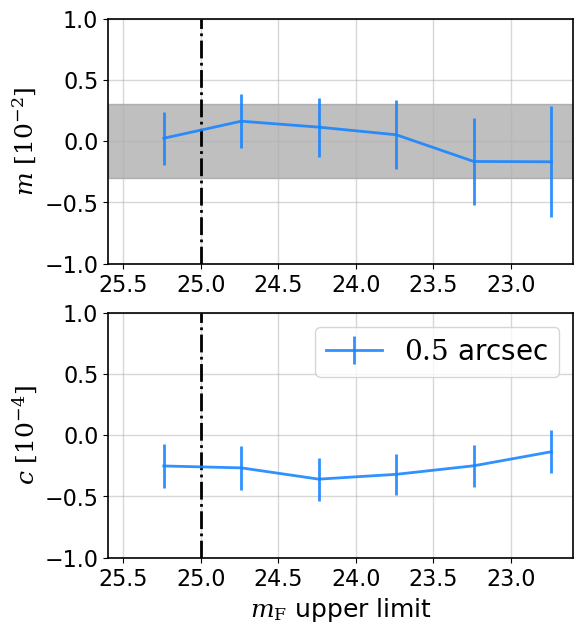

In [37]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)

# read data
outs = pyascii.read('sum_n3_basic1/try1_bin_M00.csv')
x=outs['binave']
y1=outs['mbias']
yerr=outs['merr']
z1=outs['cbias']
zerr=outs['cerr']

ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.errorbar(np.array(x)+0.04,np.array(y1)*1e2,np.array(yerr)*1e2,label=r'$0.5$ arcsec',color=pltutil.colors[1])

ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(22.6,25.6)
ax.axvline(25.,color='black',ls='-.')
ax.set_ylim(-1,1.)

ax.invert_xaxis()
ax.axhspan(-0.3,0.3,0,100,color='gray',alpha=0.5)
ax.grid()


ax=axes[1]
ax.errorbar(np.array(x)+0.04,np.array(z1)*1e4,np.array(zerr)*1e4,label=r'$0.5$ arcsec',color=pltutil.colors[1])
ax.legend()
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(22.6,25.6)
ax.axvline(25.,color='black',ls='-.')

ax.set_ylim(-1,1)
ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
plt.show()

(5000, 4, 1)
(5000, 4, 1)
(5000, 4, 1)
(5000, 4, 1)
(5000, 4, 1)
Separate galaxies into 5 bins: [26.  25.5 25.  24.5 24. ]
Multiplicative biases for those bins are:  [ 0.00078702  0.00024839  0.00050207 -0.00101507 -0.00051206]
Errors are:  [0.00106583 0.00104688 0.0011233  0.00129802 0.00155947]
Additive biases for those bins are:  [-1.51247429e-05 -2.33276893e-06  7.28464616e-06  6.74965439e-06
 -1.49029748e-05]
Errors are:  [1.80944444e-05 1.62356457e-05 1.50091379e-05 1.44859063e-05
 1.49677175e-05]
         merr        
---------------------
0.0007596272996735466
0.0008288497028317802
0.0009605248685378594
0.0011558380258859047
 0.001439519033534418


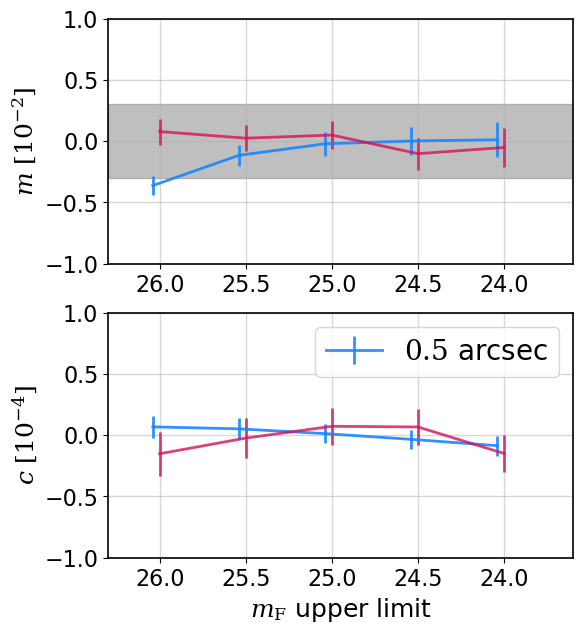

In [104]:
shear_value = 0.02
maglist = [26, 25.5, 25.0, 24.5, 24.]
res = np.zeros((4, len(maglist)))
err = np.zeros((4, len(maglist)))
nsims = np.zeros(len(maglist))
for im,mm in enumerate(maglist):
    outs=[]
    for ii in range(0,10):
        fname = './sum_n2_basic1/try1_bin_%.1f_run%d.fits' %(mm,ii)
        if os.path.isfile(fname):
            dd = fitsio.read(fname)
            outs.append(dd)
    outs = np.vstack(outs)
    print(outs.shape)
    nsims[im] = outs.shape[0]
    res[:,im] = np.average(outs, axis=0)[:,0]
    err[:,im] = np.std(outs, axis=0)[:,0]
    
mbias = (res[1] / res[3] / 2.0 - shear_value) / shear_value
merr = (err[1] / res[3] / 2.0) / shear_value / np.sqrt(nsims)
cbias = res[2] / res[3]
cerr = err[2] / res[3] / np.sqrt(nsims)

print("Separate galaxies into %d bins: %s" % (len(res[0]), res[0]))
print("Multiplicative biases for those bins are: ", mbias)
print("Errors are: ", merr)
print("Additive biases for those bins are: ", cbias)
print("Errors are: ", cerr)
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)

# read data
outs = pyascii.read('sum_n2_basic1/try1_bin_M00.csv')
msk = outs['binave']>23.5
x=outs['binave'][msk]
y1=outs['mbias'][msk]
yerr=outs['merr'][msk]
print(yerr)
z1=outs['cbias'][msk]
zerr=outs['cerr'][msk]

ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.errorbar(np.array(x)+0.04,np.array(y1)*1e2,np.array(yerr)*1e2,label=r'$0.5$ arcsec',color=pltutil.colors[1])
ax.errorbar(res[0],mbias*1e2,merr*1e2,color=pltutil.colors[2])

ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(23.6,26.3)
ax.set_ylim(-1,1.)

ax.invert_xaxis()
ax.axhspan(-0.3,0.3,0,100,color='gray',alpha=0.5)
ax.grid()

ax=axes[1]
ax.errorbar(np.array(x)+0.04,np.array(z1)*1e4,np.array(zerr)*1e4,label=r'$0.5$ arcsec',color=pltutil.colors[1])
ax.errorbar(res[0],cbias*1e4,cerr*1e4,color=pltutil.colors[2])
ax.legend()
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(23.6,26.3)
ax.set_ylim(-1,1)

ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
plt.show()

         cerr        
---------------------
0.0028660013431058406
0.0032623165156444884
0.0039359248638629885
 0.004878105103612152
 0.006237183780427416
 0.008345701476850832
(1000, 3, 5)
[10.63310812  9.88410695  7.94437757  5.52455071  3.28955212]


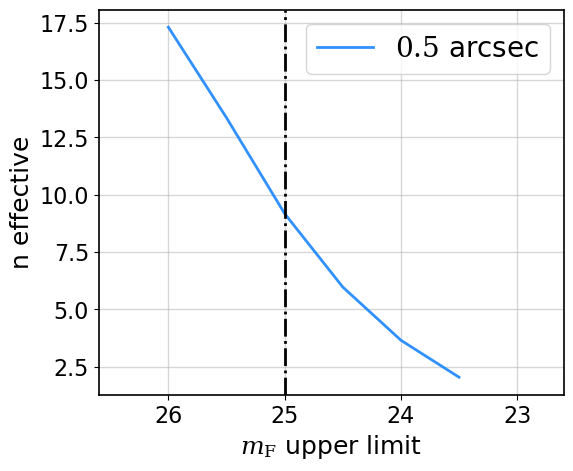

In [98]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=1,nx=1,square=False)

# read data
outs = pyascii.read('sum_n2_basic1/try1_bin_M00_neff.csv')
x=outs['binave']
y=outs['cerr']
print(y)

y=(0.25/(np.sqrt((0.2*7100/60/2.)**2.*np.pi)*y))**2.

ax=axes[0]
xlabel=r'$m_{\rm F}$ upper limit'
ax.plot(np.array(x),np.array(y),label=r'$0.5$ arcsec',color=pltutil.colors[1])


outs = []
for ii in range(2):
    fname = './sum_n2_basic1/try1_bin_neff_run%d.fits' %ii
    dd = fitsio.read(fname)
    outs.append(dd)
outs = np.vstack(outs)
print(outs.shape)

res = np.average(outs, axis=0)
err = np.std(outs, axis=0)
    
cerr = err[1] / res[2] 
cerr=(0.26/(np.sqrt((0.2*7100/60/2.)**2.*np.pi)*cerr))**2.
print(cerr)



ax.legend()
ax.set_ylabel('n effective',fontsize=18)
ax.set_xlim(22.6,26.6)
ax.axvline(25.,color='black',ls='-.')

ax.set_xlabel(xlabel,fontsize=18)
ax.grid()
ax.invert_xaxis()
plt.show()

In [71]:
a=pyfits.getdata('cat_n2_basic1/cov_matrix.fits')
10 ** (( 30.- 26) / 2.5)/np.sqrt(a[0,0])

17.445633496745927

In [72]:
for i in range(31):
    print(np.sqrt(a[i,i]))

2.281987470548174
4.464900630333161
2.955811573304918
2.9557195611009064
7.901541737074535
5.3640191331187035
5.363437387870826
1.4521278023013184
1.452129511484578
1.452127802301318
1.452129511484578
1.4521278023013184
1.452129511484578
1.452127802301318
1.452129511484578
4.164227779036544
4.154821453479522
4.164227779036545
4.154821453479522
4.164227779036544
4.154821453479522
4.164227779036545
4.154821453479522
4.154241491662426
4.163677447583512
4.154241491662426
4.163677447583511
4.154241491662426
4.163677447583512
4.154241491662427
4.163677447583512


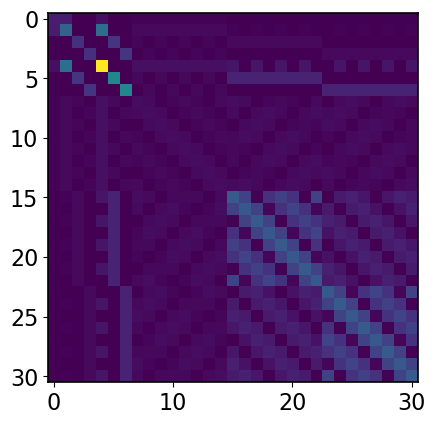

In [52]:
plt.imshow(np.abs(a))